In [48]:
# pip install networkx
# pip install matplotlib
# pip install tqdm
# pip install pandas
# pip install numpy
# pip install graphviz
# pip install scikit-learn

In [2]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [3]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

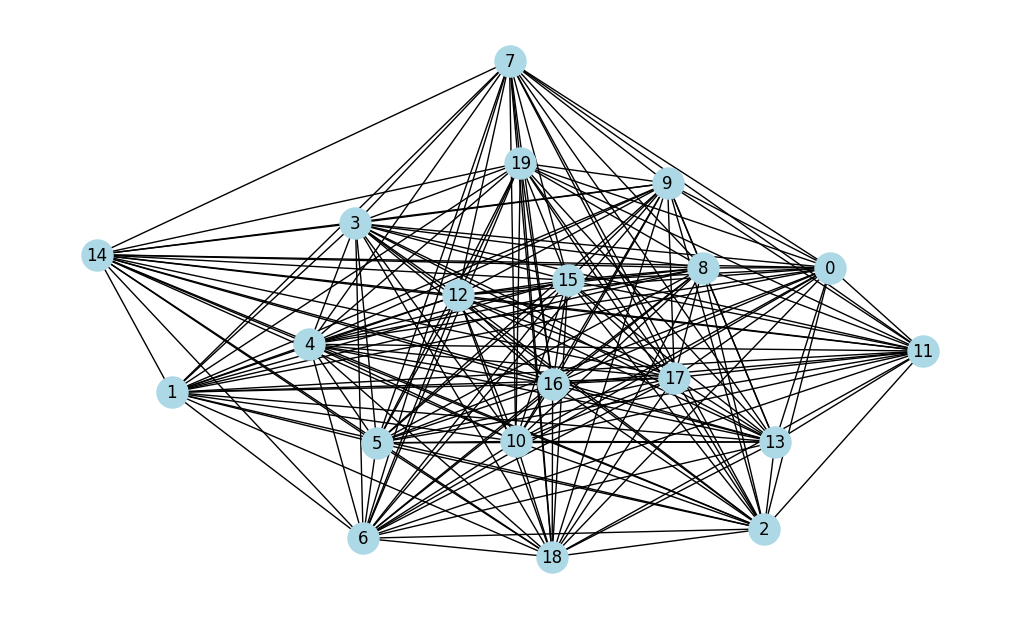

In [4]:
G = gnp_random_connected_graph(20, 1, False, True)

## Subtask 1.1

### Prim's algorithm

**Код Прима написаний нами:**

In [5]:

def prim_algorithm(G: nx.Graph):
    """Prim's algorithm"""
    my_mst = nx.Graph()


    edges = list(G.edges(data=True))
    list_of_edges = []
    for p1, p2, weig in edges:
        list_of_edges.append((p1, p2, weig['weight']))

    nodes = list(G.nodes())

    result_edges = []
    u = [nodes[0]]

    while len(u) < len(nodes):
        list_of_possible_next_edges = []

        for edg in list_of_edges:
            if (edg[0] in u and edg[1] not in u) or (edg[1] in u and edg[0] not in u):
                list_of_possible_next_edges.append(edg)

        if list_of_possible_next_edges:
            next_edge = min(list_of_possible_next_edges, key=lambda x: x[2])
            result_edges.append(next_edge)
            
            if next_edge[0] in u:
                u.append(next_edge[1])
            else:
                u.append(next_edge[0])
            
            list_of_edges.remove(next_edge)

    result_edges = sorted(result_edges, key = lambda x: x[0])
    for edge in result_edges:
        my_mst.add_edge(edge[0], edge[1], weight = edge[2])

    print("№  Ребра  Вага")
    for i, edge in enumerate(result_edges):
        print(f"{i+1}) {edge[0]} -- {edge[1]} : {edge[2]}")
    total_weight = sum(ed[2] for ed in result_edges)
    print(f'загальна вага mst: {total_weight}')
    return my_mst

№  Ребра  Вага
1) 0 -- 6 : -5
2) 1 -- 2 : -4
3) 1 -- 7 : -4
4) 1 -- 13 : -4
5) 1 -- 18 : -3
6) 2 -- 14 : -3
7) 2 -- 9 : -3
8) 3 -- 13 : -3
9) 3 -- 4 : -5
10) 4 -- 16 : -3
11) 5 -- 19 : -4
12) 6 -- 11 : -5
13) 7 -- 10 : -4
14) 8 -- 16 : -3
15) 11 -- 14 : -5
16) 12 -- 19 : -5
17) 14 -- 17 : -5
18) 15 -- 16 : -2
19) 18 -- 19 : -5
загальна вага mst: -75


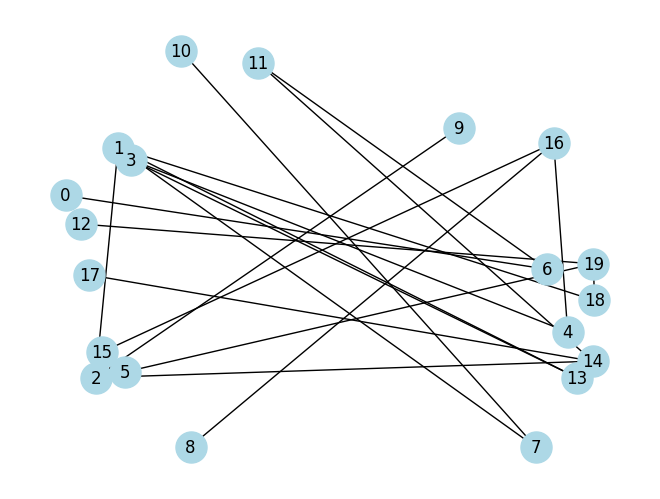

In [6]:
prim_alg = prim_algorithm(G)
nx.draw(prim_alg, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

# Звіт

##### Мацелюх Максим
##### Ласійчук Олексій

## Дослідження роботи алгоритму Прима

#### Постановка задачі

Метою роботи є реалізація алгоритму Прима для знаходження мінімального остовного дерева (MST) у зваженому графі та порівняння його ефективності з вбудованою реалізацією. Додатково проведено експериментальне дослідження продуктивності алгоритму на графах різних розмірів та зі змінною щільністю зв’язків між вершинами.

#### Методологія

- Реалізовано алгоритм Прима для знаходження MST.

- Використано вбудовану реалізацію алгоритму для порівняння швидкодії.

- Проведено експерименти на графах із розмірністю: 10, 20, 50, 100, 200, 500 вершин.

- Для кожного розміру графа змінювалася ймовірність проведення ребер (щільність графа).

- Кожен експеримент проводився кілька разів для отримання усереднених результатів.

- Виміряно час виконання алгоритмів для кожного набору параметрів.

 ### Очікувані результати

- Власна реалізація алгоритму Прима може бути повільнішою за вбудовану через оптимізації в стандартних бібліотеках.

- Продуктивність алгоритму залежить від розміру графа та його щільності.


## Програмний код алгоритму

In [7]:

def prim_algorithm(G: nx.Graph):
    """Prim's algorithm"""
    my_mst = nx.Graph()


    edges = list(G.edges(data=True))
    list_of_edges = []
    for p1, p2, weig in edges:
        list_of_edges.append((p1, p2, weig['weight']))

    nodes = list(G.nodes())

    result_edges = []
    u = [nodes[0]]

    while len(u) < len(nodes):
        list_of_possible_next_edges = []

        for edg in list_of_edges:
            if (edg[0] in u and edg[1] not in u) or (edg[1] in u and edg[0] not in u):
                list_of_possible_next_edges.append(edg)

        if list_of_possible_next_edges:
            next_edge = min(list_of_possible_next_edges, key=lambda x: x[2])
            result_edges.append(next_edge)
            
            if next_edge[0] in u:
                u.append(next_edge[1])
            else:
                u.append(next_edge[0])
            
            list_of_edges.remove(next_edge)

    result_edges = sorted(result_edges, key = lambda x: x[0])
    for edge in result_edges:
        my_mst.add_edge(edge[0], edge[1], weight = edge[2])


## Програмний код проведення експериментів


In [8]:
import time
from tqdm import tqdm

##### Для графа на 10 вершинах з ймовірністю проведення ребра 0.3

In [9]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(10, 0.3, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS


100%|██████████| 1000/1000 [00:00<00:00, 14553.30it/s]


3.181982040405273e-05

In [51]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(10, 0.3, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 3921.53it/s]


0.00013193035125732422

##### Для графа на 10 вершинах з ймовірністю проведення ребра 0.7

In [52]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(10, 0.7, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 3286.66it/s]


0.00013987636566162109

In [53]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(10, 0.7, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 2842.73it/s]


0.00018822002410888672

##### Для графа на 20 вершинах з ймовірністю проведення ребра 0.3

In [54]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(20, 0.3, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 1692.20it/s]


0.00023687267303466796

In [59]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(20, 0.3, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 1025.42it/s]


0.0006379213333129883

##### Для графа на 20 вершинах з ймовірністю проведення ребра 0.7

In [69]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(20, 0.7, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 1108.99it/s]


0.00034179425239562987

In [66]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(20, 0.7, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 537.84it/s]


0.0012905886173248291

##### Для графа на 50 вершинах з ймовірністю проведення ребра 0.3

In [73]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(50, 0.3, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:02<00:00, 399.41it/s]


0.0008219335079193115

In [74]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(50, 0.3, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:13<00:00, 76.32it/s]


0.011519617795944214

##### Для графа на 50 вершинах з ймовірністю проведення ребра 0.7

In [75]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(50, 0.7, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:04<00:00, 224.65it/s]


0.001384521245956421

In [76]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(50, 0.7, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:26<00:00, 37.87it/s]


0.023779824256896974

##### Для графа на 100 вершинах з ймовірністю проведення ребра 0.3

In [77]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.3, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:08<00:00, 116.86it/s]


0.0025807521343231203

In [78]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.3, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]


0.12633472037315369

##### Для графа на 100 вершинах з ймовірністю проведення ребра 0.7

In [10]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.7, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:04<00:00, 201.59it/s]


0.0018733499050140382

In [11]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.7, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

  8%|▊         | 76/1000 [00:13<02:45,  5.58it/s]


KeyboardInterrupt: 

##### Для графа на 200 вершинах з ймовірністю проведення ребра 0.3

In [82]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(200, 0.3, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:28<00:00, 34.85it/s]


0.011145938158035279

In [84]:
NUM_OF_ITERATIONS = 100
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(200, 0.3, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


1.5266113233566285

##### Для графа на 200 вершинах з ймовірністю проведення ребра 0.7

In [85]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(200, 0.7, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:48<00:00, 20.76it/s]


0.023271800994873047

In [86]:
NUM_OF_ITERATIONS = 100
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(200, 0.7, False)
    
    start = time.time()
    prim_algorithm(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


3.2430348587036133

### Результати


Експерименти проводились за таким планом: 
1. Для кількості вершин 100<:
Kожен на 1000 ітерацій, кожен по 10 раз, з яких вибирався найменший час проведення експерименту.

2. Для 100 і більше вершин:
Кожен на 100 ітерацій, кожен по 5 раз, з яких вибирався найменший час проведення експерименту. Результат нашого алгоритму множився на 10, щоб відповідати результатам вбудованого алгоритму

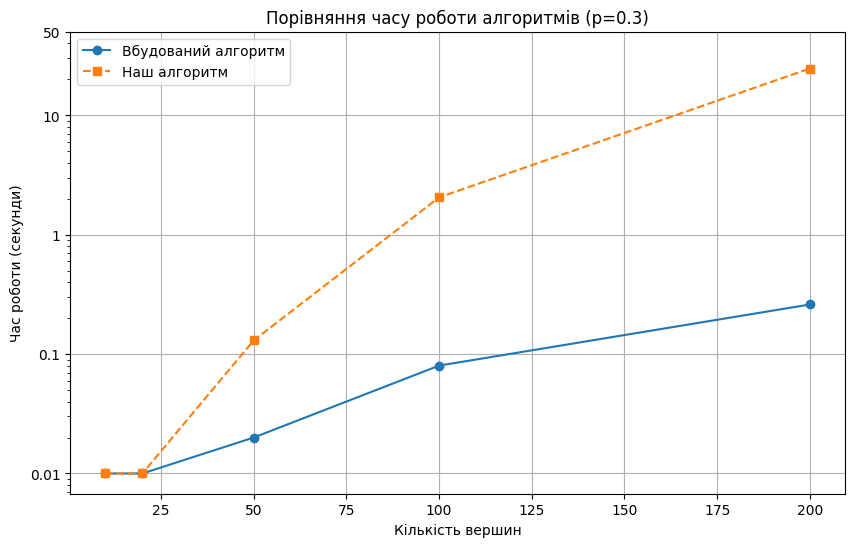

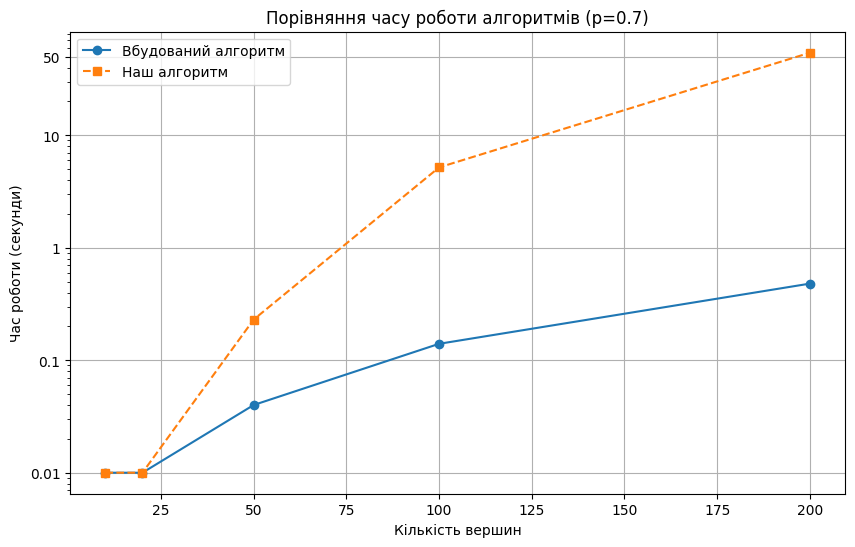

In [1]:
import matplotlib.pyplot as plt

def plot_graph_comparison(sizes, builtin_times, custom_times, probability):
    """
    Будує графік часу роботи двох алгоритмів.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, builtin_times, marker='o', linestyle='-', label='Вбудований алгоритм')
    plt.plot(sizes, custom_times, marker='s', linestyle='--', label='Наш алгоритм')

    plt.xlabel("Кількість вершин")
    plt.ylabel("Час роботи (секунди)")
    plt.title(f"Порівняння часу роботи алгоритмів (p={probability})")
    plt.legend()
    plt.grid(True)

    # Робимо шкалу Y логарифмічною, але з нормальними підписами
    plt.yscale("log")
    plt.yticks([0.01, 0.1, 1, 10, 50], ["0.01", "0.1", "1", "10", "50"])

    plt.show()


sizes = [10, 20, 50, 100, 200]  # Кількість вершин
builtin_times = [0.01, 0.01, 0.02, 0.08, 0.26]  # Час роботи вбудованого алгоритму
custom_times = [0.01, 0.01, 0.13, 2.05, 24.6]  # Час роботи власного алгоритму

plot_graph_comparison(sizes, builtin_times, custom_times, 0.3)
# 0ю3 - це probability of edge occur, крч ймовірність того що ребро буде проведене

builtin_times = [0.01, 0.01, 0.04, 0.14, 0.48]  # Час роботи вбудованого алгоритму
custom_times = [0.01, 0.01, 0.23, 5.18, 54.2]  # Час роботи власного алгоритму

plot_graph_comparison(sizes, builtin_times, custom_times, 0.7)


| Кількість вершин, шанс проведення ребра | Вбудований алгоритм | Наш алгоритм |
|-----------------------------------------|----------------------|-------------|
| 10, 0.3  | 0.01< | 0.01< |
| 10, 0.7  | 0.01< | 0.01< |
| 20, 0.3  | 0.01< | 0.01< |
| 20, 0.7  | 0.01< | 0.01 |
| 50, 0.3  | 0.02 | 0.13 |
| 50, 0.7  | 0.04 | 0.23 |
| 100, 0.3 | 0.08 | 2.05 |
| 100, 0.7 | 0.14 | 5.18 |
| 200, 0.3 | 0.26 | 24.6 |
| 200, 0.7 | 0.48 | 54.2 |


### Висновок: 
Як бачимо з результатів наш алгоритм нічим не гірший за вбудований алгоритм на невеликій кількості вершин. Але з збільшенням кількості вершин бачимо як час виконання нашого алгоритму швидко зростає, що логічно, адже алгоритм не досконалий. Також на великій кількості вершин стає замітним сильний вплив ймовірності створення ребра між будь-якими двома вершинами. Наприклад бачимо, що починаючи з графів у яких >100 вершин, час, за який відбувається побудова мінімального каркасу збільшується більш ніж удвічі у графах з ймовірністю проведення ребра 0.7, порівняно з графом у якому ймовірность створення ребра між будь-якими двома вершинами = 0.3

## Subtask 1.2

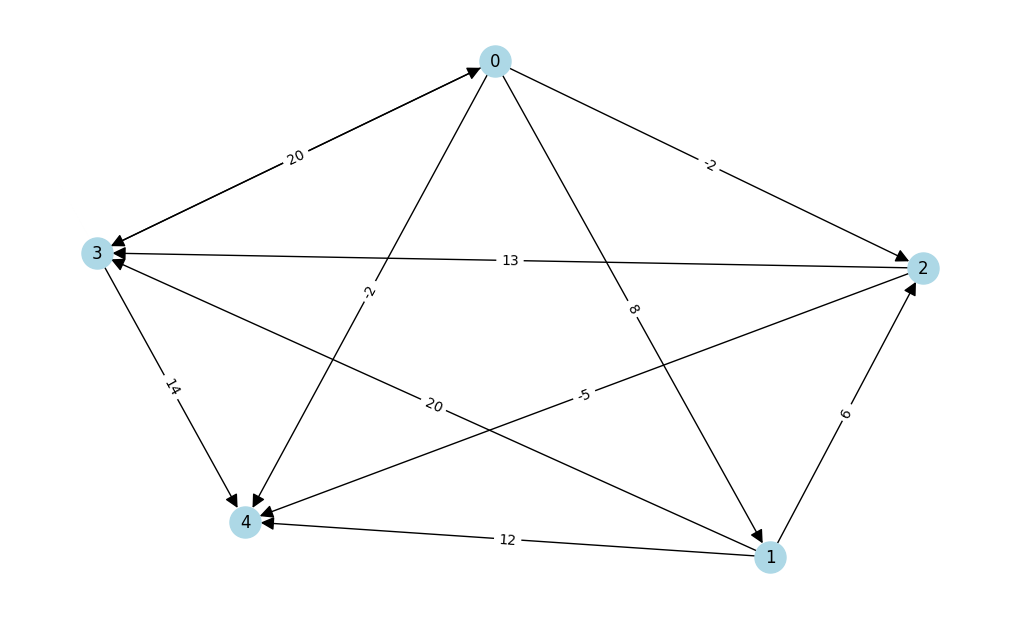

In [30]:
G = gnp_random_connected_graph(5, 0.8, True, True)

### Bellman-Ford algorithm

In [31]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 1: 8
Distance to 2: -2
Distance to 3: 11
Distance to 4: -7


**Алгоритм Белмана-Форда реалізований нами:**

In [28]:
def bellman_ford(G: nx.Graph):
    """Bellman Ford implementation"""
    edges = list(G.edges(data=True))
    list_of_edges = []
    for p1, p2, weig in edges:
        list_of_edges.append((p1, p2, weig['weight']))
    vertices = list(G.nodes())
    dist = {v: float('inf') for v in vertices}
    dist[0] = 0

    for _ in range(len(vertices) - 1):
        for u, v, weight in list_of_edges:
            if dist[u] != float('inf') and dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
    
    for u, v, weight in list_of_edges:
        if dist[u] != float('inf') and dist[u] + weight < dist[v]:
            print("Kaput! there is negative cycle ")
            return None
    
    return dist

In [32]:


try:
    dist = bellman_ford(G)
    
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 1: 8
Distance to 2: -2
Distance to 3: 11
Distance to 4: -7


# Звіт

##### Мацелюх Максим
##### Ласійчук Олексій

## Дослідження роботи алгоритму Беллмана-Форда

#### Постановка задачі
Метою даної роботи є дослідження ефективності алгоритму Беллмана-Форда для знаходження найкоротших шляхів у графі. Було реалізовано власну версію алгоритму та проведено порівняння з вбудованою реалізацією NetworkX. 

Дослідження виконувалося для різних розмірів графа: 10, 20, 50, 100, 200 вершин. Також досліджувалася поведінка алгоритму при зміні щільності графа, тобто ймовірності створення ребер між двома вершинами (0.3 і 0.7). 

Окрім цього, проведено аналіз впливу від'ємних ваг ребер, а також поведінки алгоритму у випадку наявності циклів із від'ємною вагою.

#### Методика експерименту
1. **Генерація випадкових орієнтованих графів**
   - Використано генерацію графів із заданою кількістю вершин та ймовірністю наявності ребра між довільними двома вершинами.

2. **Запуск алгоритмів**
   - Реалізовано власний алгоритм Беллмана-Форда.
   - Для порівняння використано вбудований алгоритм 
   - Для кожного набору параметрів (розмір графа, ймовірність ребер, наявність від'ємних ваг) алгоритми запускалися достатню кількість разів для усереднення часу виконання.

3. **Порівняння результатів**
   - Вимірювався середній час виконання кожного алгоритму.
   - Аналізувалася коректність знаходження найкоротших шляхів.
   - Досліджувалася поведінка при наявності циклів із від'ємною вагою (очікується, що алгоритм виявить такі цикли).

## Програмний код алгоритму

In [110]:
def bellman_ford(G: nx.Graph):
    """Bellman Ford implementation"""
    edges = list(G.edges(data=True))
    list_of_edges = []
    for p1, p2, weig in edges:
        list_of_edges.append((p1, p2, weig['weight']))
    vertices = list(G.nodes())
    dist = {v: float('inf') for v in vertices}
    dist[0] = 0

    for _ in range(len(vertices) - 1):
        for u, v, weight in list_of_edges:
            if dist[u] != float('inf') and dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
    
    for u, v, weight in list_of_edges:
        if dist[u] != float('inf') and dist[u] + weight < dist[v]:
            print("Kaput! there is negative cycle ")
            return None
    
    return dist

## Програмний код проведення експериментів


In [22]:
import time
from tqdm import tqdm

##### Для графа на 10 вершинах з ймовірністю проведення ребра 0.3

In [148]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 1000
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(10, 0.3, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 1000/1000 [00:00<00:00, 6352.42it/s]


In [149]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(10, 0.3, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 5841.10it/s]


8.937954902648926e-05

##### Для графа на 10 вершинах з ймовірністю проведення ребра 0.7

In [150]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 1000
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(10, 0.7, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 4254.37it/s]


In [151]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(10, 0.7, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 3430.78it/s]


0.00015984439849853516

##### Для графа на 20 вершинах з ймовірністю проведення ребра 0.3

In [158]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 1000
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(20, 0.3, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 1000/1000 [00:00<00:00, 1561.95it/s]


In [153]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(20, 0.3, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:00<00:00, 1220.41it/s]


0.0005643138885498047

##### Для графа на 20 вершинах з ймовірністю проведення ребра 0.7

In [154]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 1000
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(20, 0.7, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 1000/1000 [00:01<00:00, 870.98it/s]


In [155]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(20, 0.7, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:01<00:00, 660.61it/s]


0.001087202787399292

##### Для графа на 50 вершинах з ймовірністю проведення ребра 0.3

In [156]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 1000
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(50, 0.3, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 1000/1000 [00:05<00:00, 167.19it/s]


In [157]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(50, 0.3, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:08<00:00, 117.95it/s]


0.007107251405715943

##### Для графа на 50 вершинах з ймовірністю проведення ребра 0.7

In [159]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 1000
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(50, 0.7, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 1000/1000 [00:10<00:00, 91.19it/s]


In [160]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(50, 0.7, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:18<00:00, 55.17it/s]


0.015764480590820314

##### Для графа на 100 вершинах з ймовірністю проведення ребра 0.3

In [161]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 1000
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(100, 0.3, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 1000/1000 [00:36<00:00, 27.09it/s]


In [162]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.3, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [01:00<00:00, 16.66it/s]


0.05468403601646423

##### Для графа на 100 вершинах з ймовірністю проведення ребра 0.7

In [163]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 1000
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(100, 0.7, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 1000/1000 [01:10<00:00, 14.19it/s]


In [ ]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.7, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


0.13273629665374756

##### Для графа на 200 вершинах з ймовірністю проведення ребра 0.3

In [166]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 100
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(200, 0.3, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


In [167]:
NUM_OF_ITERATIONS = 100
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(200, 0.3, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


0.4432226729393005

##### Для графа на 200 вершинах з ймовірністю проведення ребра 0.7

In [168]:
from networkx.exception import NetworkXUnbounded
NUM_OF_ITERATIONS = 100
time_taken = 0
valid_iterations = 0

for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    G = gnp_random_connected_graph(200, 0.7, directed=True)
    try:
        start = time.time()
        bellman_ford_predecessor_and_distance(G, source=0)
        end = time.time()
        
        time_taken += end - start
        valid_iterations += 1

    except NetworkXUnbounded:
        pass



100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


In [170]:
NUM_OF_ITERATIONS = 100
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(200, 0.7, False)
    
    start = time.time()
    bellman_ford(G)
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


1.0976535367965699

### Результати


Експерименти проводились за таким планом: 
1. Для кількості вершин 100<:
Kожен на 1000 ітерацій, кожен по 10 раз, з яких вибирався найменший час проведення експерименту.

2. Для 100 і більше вершин:
Кожен на 100 ітерацій, кожен по 5 раз, з яких вибирався найменший час проведення експерименту. Результат нашого алгоритму множився на 10, щоб відповідати результатам вбудованого алгоритму

| Кількість вершин, ймовірність ребра | Вбудований алгоритм | Власний алгоритм |
|-------------------------------------|---------------------|-----------------|
| 10, 0.3  | 0.01< | 0.01< |
| 10, 0.7  | 0.01< | 0.01< |
| 20, 0.3  | 0.01< | 0.01< |
| 20, 0.7  | 0.01  | 0.01  |
| 50, 0.3  | 0.05  | 0.08  |
| 50, 0.7  | 0.9 | 0.17 |
| 100, 0.3 | 0.34 | 0.58 |
| 100, 0.7 | 1.07 | 2.24 |
| 200, 0.3 | 4.11 | 7.57 |
| 200, 0.7 | 8.26 | 18.79 |

### Висновок:
Результати експериментів показують, що власний алгоритм має схожу продуктивність із вбудованим для малих графів (до 50 вершин). Однак зі збільшенням розміру графа ефективність нашого алгоритму значно падає, особливо для густих графів. Найбільша різниця у швидкодії спостерігається при 200 вершинах і 0.7 ймовірності ребра, де наш алгоритм працює більше ніж у два рази повільніше за вбудований, і очевидно, що зі збільшенням кількості вершин й густоти графа ця різниця також буде швидко збльшуватись. Це можна пояснити відсутністю оптимізацій у нашій реалізації і відсутністю у нас професійного досвіду написання ефективних алгоритмів)

---

## Some useful explanations
### How to get list of edges for your algorithm

In [14]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [15]:
edges[:5]

[(0, 1), (0, 9), (1, 6), (1, 7), (1, 8)]

### To get edges with weights

In [16]:
edges = list(G.edges(data=True))

In [17]:
edges[:5]

[(0, 1, {'weight': 8}),
 (0, 9, {'weight': 6}),
 (1, 6, {'weight': 3}),
 (1, 7, {'weight': 8}),
 (1, 8, {'weight': 8})]

In [18]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [19]:
import time
from tqdm import tqdm

In [ ]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:10<00:00, 96.73it/s]


0.0030482113361358643

## Task 2. Decision Tree Classifier 

In [7]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'sklearn'

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [5]:
# Load dataset
iris = load_iris()
dir(iris)

NameError: name 'load_iris' is not defined

In [23]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [24]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

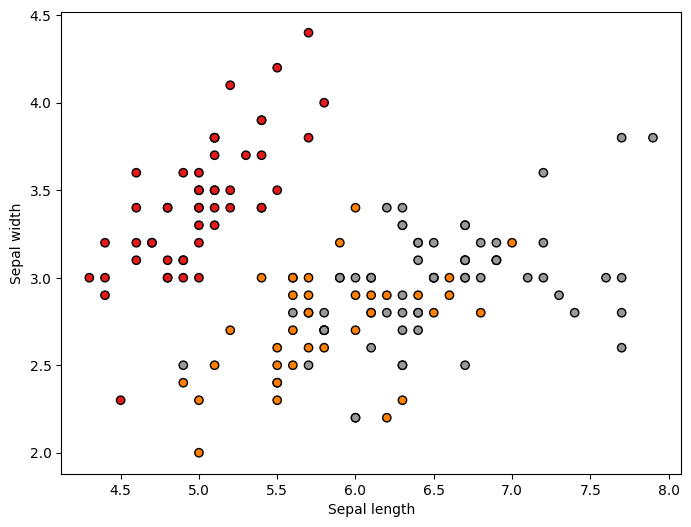

In [25]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [26]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [27]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [28]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [29]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

'iris.pdf'

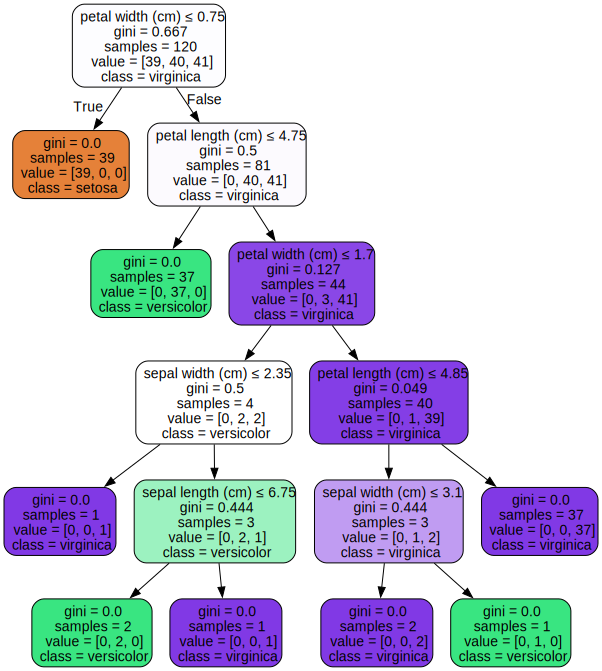

In [30]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [31]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [32]:
sum(predictions == y_test) / len(y_test)

np.float64(0.8)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [33]:
y_test

array([2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0,
       1, 2, 1, 0, 1, 1, 0, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [34]:
X_test[1]

array([4.9, 3.1, 1.5, 0.2])

In [35]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

In [36]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [37]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None
        
        
    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size


    
    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
        pass

In [38]:

def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    pass

***put your code below, with usage and evaluation of Decision classifier tree*** (delete this)